# Table of Contents
 <p><div class="lev1"><a href="#Some-maps"><span class="toc-item-num">1&nbsp;&nbsp;</span>Some maps</a></div><div class="lev2"><a href="#Example-maps-of-precipitation,-omega_500,-qvstar_925"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Example maps of precipitation, omega_500, qvstar_925</a></div><div class="lev3"><a href="#Daily"><span class="toc-item-num">1.1.1&nbsp;&nbsp;</span>Daily</a></div><div class="lev2"><a href="#Example-maps-of-coarsened-precipitation"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Example maps of coarsened precipitation</a></div><div class="lev3"><a href="#Coasen-in-time"><span class="toc-item-num">1.2.1&nbsp;&nbsp;</span>Coasen in time</a></div><div class="lev3"><a href="#Coarsen-in-space"><span class="toc-item-num">1.2.2&nbsp;&nbsp;</span>Coarsen in space</a></div><div class="lev1"><a href="#Figures-at-a-specific-scale"><span class="toc-item-num">2&nbsp;&nbsp;</span>Figures at a specific scale</a></div><div class="lev1"><a href="#Multiscale-figures"><span class="toc-item-num">3&nbsp;&nbsp;</span>Multiscale figures</a></div>

In [2]:
%load_ext autoreload
%matplotlib inline

In [11]:
%autoreload 2

import pandas as pd
import numpy as np
import numpy.ma as ma
import dask.array as da
import matplotlib.pyplot as plt
import datetime as dt
import sys,os,glob
import matplotlib
from mpl_toolkits.basemap import Basemap
from matplotlib.colors import LogNorm

## Add own library to path
workdir = os.getcwd()
thismodule = sys.modules[__name__]
moduledir = os.path.join(os.path.dirname(workdir),'functions')
sys.path.insert(0,moduledir)
print("Own modules available:", [os.path.splitext(os.path.basename(x))[0]
                                 for x in glob.glob(os.path.join(moduledir,'*.py'))])

## Load own libraries
from importingData import *
from scalingApproximations import *
from plotMaps import *
from plot1DInvLog import *
from statisticalDistributions import *
from slicingAndSubsetting import *
from outputResults import *
from CAMsettings import *
from plot2D import *

## Graphical parameters
plt.style.use(os.path.join(matplotlib.get_configdir(),'stylelib/presentation.mplstyle'))

Own modules available: ['CAMsettings', 'daskOptions', 'environmentAndDirectories', 'importingData', 'outputResults', 'physicalConstants', 'plot1DInvLog', 'plot2D', 'plotMaps', 'scalingApproximations', 'slicingAndSubsetting', 'statisticalDistributions', 'thermoConstants', 'thermoFunctions']


In [ ]:
time_strides = '1h','3h','6h','12h','1d','2d','4d','8d'
resolutions = '1dx','2dx','3dx','4dx','5dx','6dx','7dx','8dx'
N_times = len(time_strides)
N_res = len(resolutions)

print("choose run options")
scaling = 'omega500tsps'
compset = 'FSPCAMm_AMIP'
# compset = 'FAMIPC5'
experiment = 'piControl'
member = 'r1i1p1'
subset = 'tropics'
dates_label = '185005010100-185105010000'
ranks_label = 'Q8-Q41'
time_ref = '1h'
res_ref = '1dx'
daskarray = False

In [136]:
print("missing results")
for experiment in 'piControl','abrupt4xCO2':
    for compset in 'FSPCAMm_AMIP','FAMIPC5':

        resultdir = os.path.join(os.path.dirname(workdir),'results','omega500tsps',compset,experiment,member,subset)
        missing_dictionary = []
        for time_stride in time_strides:
            for resolution in resolutions:
                filename = 'results_dictionary_%s_%s.pickle'%(ranks_label,dates_label)
                dirpath = os.path.join(resultdir,time_stride,resolution)
                if not np.any(['dictionary' in p for p in glob.glob(os.path.join(dirpath,'*'))]):
                    missing_dictionary.append("%s_%s"%(time_stride,resolution))

        print(experiment,compset,missing_dictionary)

missing results
piControl FSPCAMm_AMIP ['1h_1dx']
piControl FAMIPC5 ['1h_1dx']
abrupt4xCO2 FSPCAMm_AMIP ['1h_1dx', '1h_2dx', '1h_3dx', '1h_4dx', '1h_5dx', '1h_6dx', '1h_7dx', '1h_8dx', '1h_9dx']
abrupt4xCO2 FAMIPC5 ['1h_1dx', '1h_2dx', '1h_3dx', '1h_4dx', '1h_5dx', '1h_6dx', '1h_7dx', '1h_8dx', '1h_9dx']


In [79]:
# Results to analyze
resultdir = os.path.join(os.path.dirname(workdir),'results','omega500tsps',compset,experiment,member,subset)

# Figure output directory
figdir = os.path.join(os.path.dirname(workdir),'figures','omega500tsps',compset,experiment,member,subset)

print()
print("get inputpaths")

# Local input directory
historyFilesSettings = getCAMHistoryFilesSettings()
inputdir, inputdir_processed_day, inputdir_processed_1hr, inputdir_results, inputdir_fx = \
    getInputDirectories(compset,experiment)

choose run options

get inputpaths


# Some maps

## Example maps of precipitation, omega_500, qvstar_925

In [87]:
## Get longitude, latitude and landmask
print("load lontigude, latitude and landmask")

fh = Dataset(os.path.join(inputdir_fx,'landmask_fx_CESM111-SPCAM20_allExperiments_r0i0p0.nc'))
lon1D = fh.variables['lon'][:]
lat1D = fh.variables['lat'][:]
lon2D, lat2D = np.meshgrid(lon1D,lat1D)
lon2D = da.from_array(lon2D,chunks=lon2D.shape)
lat2D = da.from_array(lat2D,chunks=lat2D.shape)


landmask = fh.variables['landmask']


load lontigude, latitude and landmask


In [88]:
print("load physical variables data")

omega_id = 'OMEGA'
pr_id = 'PRECT'
ts_id = 'TS'
ta_id = 'T'
relhum_id = 'RELHUM'
ps_id = 'PS'
dates_maps = '185005010100','185005020000'
handle = 'h0'

output_suffix_maps = '%s'%('-'.join(dates_maps))

omega,pr,ta,relhum,ps = \
    getValues([omega_id,pr_id,ta_id,relhum_id,ps_id],
              compset,subset,experiment,time_ref,res_ref,
              daskarray=daskarray,dates=dates_maps,handle=handle)
pr *= rho_l    # convert from m/s to kg/m2/s

print("compute pressure levels")
    
input_lev_file = os.path.join(inputdir_fx,'lev_fx_CESM111-SPCAM20_allExperiments_r0i0p0.nc')
computeP = getPressureCoordinateFunction(input_lev_file)
pres = computeP(ps)

load physical variables data
Importing OMEGA, PRECT, T, RELHUM, PS from 24 history files between 1850-05-01-03600 and 1850-05-02-00000
compute pressure levels


In [89]:
# %%time
print("compute 2D surfaces of predictor variables")
p_500 = 50000
p_925 = 92500; levdim=1
omega_500 = isobaricSurface(omega,pres,p_ref=p_500,levdim=levdim)
use925 = True
if use925:
    ta_925 = isobaricSurface(ta,pres,p_ref=p_925,levdim=levdim) 
    qvstar_925 = saturationSpecificHumidity(ta_925,p_925*np.ones(ps.shape))
else:
    qvstar_s = saturationSpecificHumidity(ts,ps)

compute 2D surfaces of predictor variables


### Daily

In [90]:
print("coarsen variables to daily")
pr_day = coarsenTimeStride(pr,'1d')
omega_500_day = coarsenTimeStride(omega_500,'1d')
qvstar_925_day = coarsenTimeStride(qvstar_925,'1d')

coarsen variables to daily


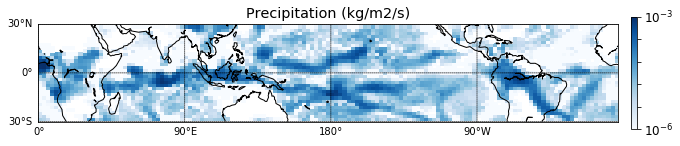

In [113]:
plotMapTropics(lon2D,lat2D,pr_day[0],title='Precipitation (kg/m2/s)',cmap=plt.cm.Blues,
               v_min=1e-6,v_max=1e-3,mode='log',plotfunction='pcolormesh')
plt.savefig(os.path.join(figdir,'talkAGU2017_map_pr_day_%s_%s.pdf'%(compset,output_suffix_maps)),
            bbox_inches='tight')

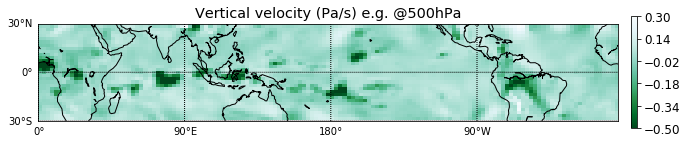

In [114]:
plotMapTropics(lon2D,lat2D,omega_500[0],title='Vertical velocity (Pa/s) e.g. @500hPa',cmap=plt.cm.BuGn_r,
               v_min=-0.5,v_max=0.3,mode='linear',plotfunction='pcolormesh')
plt.savefig(os.path.join(figdir,'talkAGU2017_map_omega_500_day_%s_%s.pdf'%(compset,output_suffix_maps)),
            bbox_inches='tight')

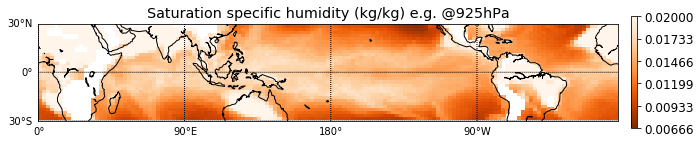

In [115]:
plotMapTropics(lon2D,lat2D,qvstar_925[0],title='Saturation specific humidity (kg/kg) e.g. @925hPa',cmap=plt.cm.Oranges_r,
               v_max=0.02,mode='linear',plotfunction='pcolormesh')
plt.savefig(os.path.join(figdir,'talkAGU2017_map_qvstar_925_day_%s_%s.pdf'%(compset,output_suffix_maps)),
            bbox_inches='tight')

## Example maps of coarsened precipitation

### Coasen in time

In [71]:
print("coarsen pr to weekly")
pr_week = coarsenTimeStride(pr,'7d')


coarsen pr to weekly


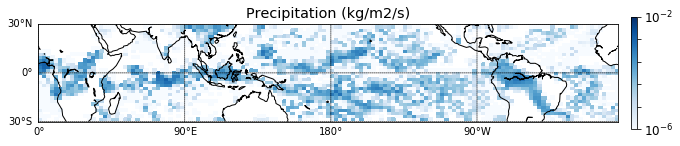

In [116]:
plotMapTropics(lon2D,lat2D,pr[10],title='Precipitation (kg/m2/s)',cmap=plt.cm.Blues,
               v_min=1e-6,v_max=1e-2,mode='log',plotfunction='pcolormesh')
plt.savefig(os.path.join(figdir,'talkAGU2017_map_pr_1h_%s_%s.pdf'%(compset,output_suffix_maps)),
            bbox_inches='tight')

In [96]:
plotMapTropics(lon2D,lat2D,pr_week[10],title='Precipitation (kg/m2/s)',cmap=plt.cm.Blues,
               v_min=1e-6,v_max=1e-2,mode='log',plotfunction='pcolormesh')
plt.savefig(os.path.join(figdir,'talkAGU2017_map_pr_week_%s_%s.pdf'%(compset,output_suffix_maps)),
            bbox_inches='tight')

IndexError: index 10 is out of bounds for axis 0 with size 0

### Coarsen in space

In [108]:
print("coarsen pr in space")
pr_day_2dx = coarsenResolution(pr_day,'2dx')
pr_day_4dx = coarsenResolution(pr_day,'4dx')

lon2D_2dx = coarsenResolution(lon2D,'2dx')
lon2D_4dx = coarsenResolution(lon2D,'4dx')
lat2D_2dx = coarsenResolution(lat2D,'2dx')
lat2D_4dx = coarsenResolution(lat2D,'4dx')

coarsen pr in space


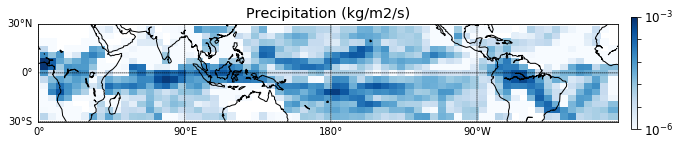

In [117]:
plotMapTropics(lon2D_2dx,lat2D_2dx,pr_day_2dx[0],title='Precipitation (kg/m2/s)',cmap=plt.cm.Blues,
               v_min=1e-6,v_max=1e-3,mode='log',plotfunction='pcolormesh')
plt.savefig(os.path.join(figdir,'talkAGU2017_map_pr_day_2dx_%s_%s.pdf'%(compset,output_suffix_maps)),
            bbox_inches='tight')

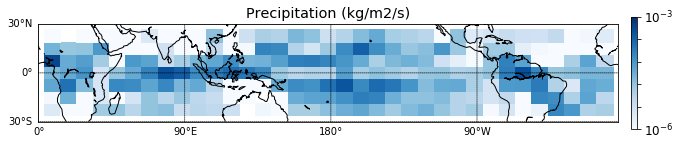

In [118]:
plotMapTropics(lon2D_4dx,lat2D_4dx,pr_day_4dx[0],title='Precipitation (kg/m2/s)',cmap=plt.cm.Blues,
               v_min=1e-6,v_max=1e-3,mode='log',plotfunction='pcolormesh')
plt.savefig(os.path.join(figdir,'talkAGU2017_map_pr_day_4dx_%s_%s.pdf'%(compset,output_suffix_maps)),
            bbox_inches='tight')

# Figures at a specific scale

In [119]:
import pickle

In [125]:
time_strides = '1h','3h','6h','12h','1d','2d','4d','8d'
resolutions = '1dx','2dx','3dx','4dx','5dx','6dx','7dx','8dx','9dx'
N_times = len(time_strides)
N_res = len(resolutions)

print("Load results as a dictionary")
results = {}
for time_stride in time_strides:
    results[time_stride] = {}
    for resolution in resolutions:
        filename = 'results_dictionary_%s_%s.pickle'%(ranks_label,dates_label)
        filepath = os.path.join(resultdir,time_stride,resolution,filename)
        results[time_stride][resolution] = pickle.load(open(filepath,'rb'))

all_varids = results[time_ref][res_ref].keys()

Load results as a dictionary


FileNotFoundError: [Errno 2] No such file or directory: '/Users/bfildier/Code/researchProjects/dataAnalysis/extremeRainPredictabilityAcrossScales/results/omega500tsps/FSPCAMm_AMIP/piControl/r1i1p1/tropics/1h/1dx/results_dictionary_Q8-Q41_185005010100-185105010000.pickle'

# Multiscale figures

In [ ]:
results_dictionary_Q8-Q41_185005010100-185105010000.pickle